In [1]:
import pandas as pd
import sys
# Path to the directory just above 'Code'
sys.path.append('/Users/maxguo/Desktop/TS_Forecasting_Project/TS_Forecasting_Project')
from Code.Load import Loaded_Data as ld
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = ld.combined_data

In [3]:
df = df.dropna()
df

,regionid,sizerank,regionname,regiontype,statename,new construction sales count,new construction mean sales price ($),mean days to pending,mean price cut ($),mean price cut (%),median sales price ($),percent sold above list (%),zillow home value index,zillow observed rent index
date,,,,,,,,,,,,,,
2018-03-31,394318,70,"Allentown, PA",msa,PA,3569.0,3569.0,75.0,9741.195900,0.043092,166417.0,0.204779,202386.418309,1160.500802
2018-03-31,394938,59,"Omaha, NE",msa,NE,3001.0,3001.0,40.0,8632.670138,0.031699,161500.0,0.255864,180255.182529,940.182116
2018-03-31,395238,58,"Worcester, MA",msa,MA,2468.0,2468.0,43.0,10482.388389,0.036609,230083.0,0.257109,272443.059434,1258.548255
2018-03-31,394457,75,"Charleston, SC",msa,SC,5599.0,5599.0,48.0,13616.405507,0.023719,242067.0,0.158752,263293.850788,1322.089194
2018-03-31,395244,122,"York, PA",msa,PA,1845.0,1845.0,62.0,7746.713833,0.038287,157350.0,0.159936,179415.973655,872.372255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,395061,175,"San Luis Obispo, CA",msa,CA,536.0,536.0,46.0,47550.841747,0.037885,823167.0,0.299090,891598.611902,3102.695275
2024-02-29,394361,202,"Barnstable Town, MA",msa,MA,958.0,958.0,45.0,64811.244245,0.046374,620667.0,0.253708,706965.263181,2674.577505
2024-02-29,394454,209,"Champaign, IL",msa,IL,361.0,361.0,35.0,9684.378637,0.041944,176500.0,0.282948,198835.413153,1138.399474


In [4]:
# Export DataFrame to CSV
df.to_csv('output.csv', index=True)

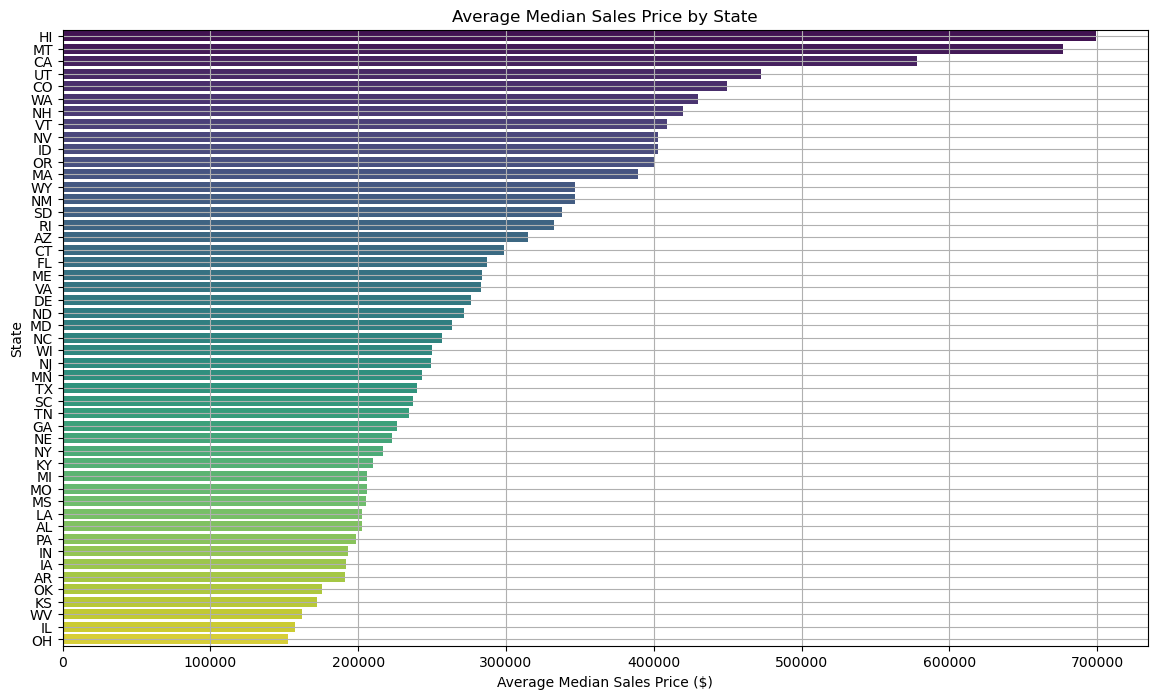

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by state and calculate the mean of median sales price
state_median_price = df.groupby('statename')['median sales price ($)'].mean().sort_values(ascending=False)

# Plotting the average median sales prices for each state
plt.figure(figsize=(14, 8))
sns.barplot(x=state_median_price.values, y=state_median_price.index, palette='viridis')
plt.title('Average Median Sales Price by State')
plt.xlabel('Average Median Sales Price ($)')
plt.ylabel('State')
plt.grid(True)
plt.show()


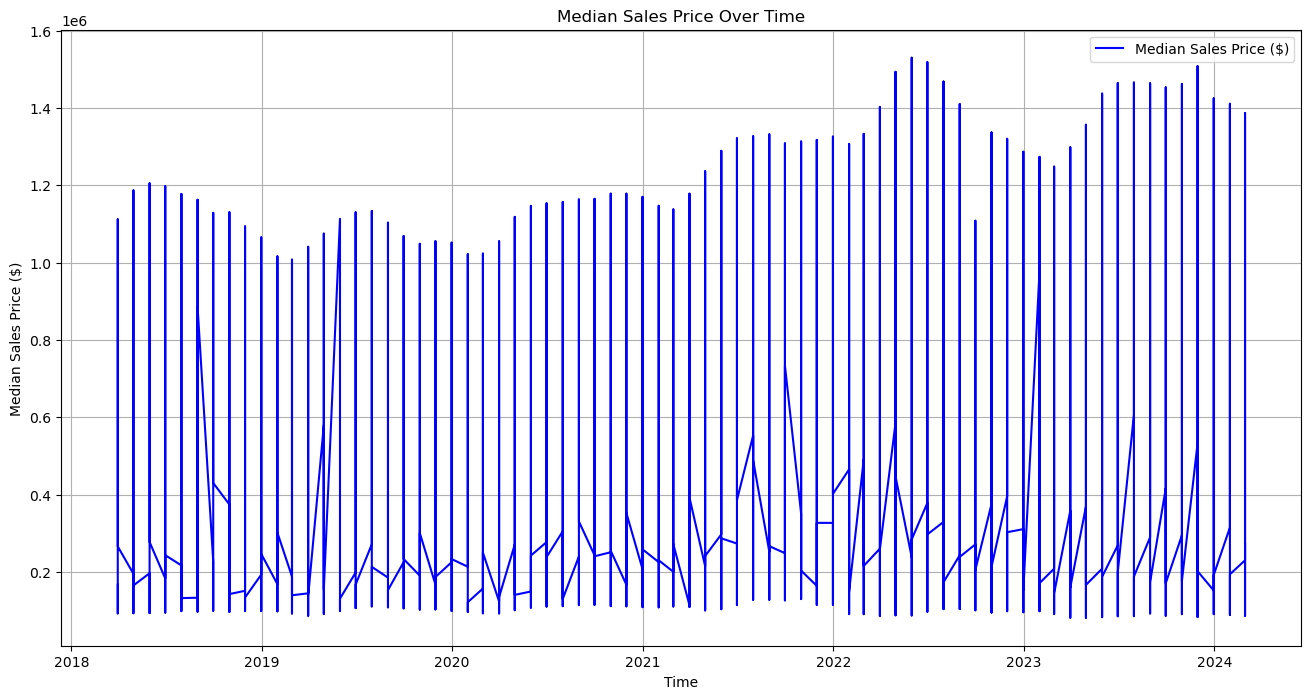

In [6]:
# Plotting the median sales price over time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['median sales price ($)'], label='Median Sales Price ($)', color='blue')
plt.title('Median Sales Price Over Time')
plt.xlabel('Time')
plt.ylabel('Median Sales Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['median sales price ($)'])

adf_result = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Number of Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_result


{'ADF Statistic': -12.317363962499417,
 'p-value': 6.873441315966451e-23,
 'Number of Lags Used': 42,
 'Number of Observations Used': 18646,
 'Critical Values': {'1%': -3.4307007562198417,
  '5%': -2.861695021301512,
  '10%': -2.5668525137106584}}

In [8]:
from pmdarima import auto_arima

# Automatically fitting the best ARIMA model
auto_arima_model = auto_arima(df['median sales price ($)'], 
                              seasonal=False,  # No seasonal component as we assume seasonality was part of initial decompose
                              trace=True, 
                              error_action='ignore', 
                              suppress_warnings=True)

# Best ARIMA model summary
auto_arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=512769.422, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=507701.619, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=512767.422, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=505600.072, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=504460.523, Time=1.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=503767.294, Time=1.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=503250.108, Time=1.59 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.09 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=503248.109, Time=1.45 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=503765.294, Time=1.23 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=9.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18689
Model:               SARIMAX(5, 1, 0)   Log Likelihood             -251618.055
Date:                Fri, 03 May 2024   AIC                         503248.109
Time:                        17:12:58   BIC                         503295.123
Sample:                             0   HQIC                        503263.541
                              - 18689                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8041      0.007   -120.775      0.000      -0.817      -0.791
ar.L2         -0.6394      0.008    -76.765      0.000      -0.656      -0.623
ar.L3         -0.4776      0.009    -53.071      0.000      -0.495      -0.460
ar.L4         -0.3191      0.008    -38.775      0.000      -0.335      -0.303
ar.L5         -0.1656      0.006    -26.599      0.000      -0.178      -0.153
sigma2        2.9e+10   1.13e-13   2.58e+23      0.000     2.9e+10     2.9e+10
===================================================================================
Ljung-Box (L1) (Q):                  10.87   Jarque-Bera (JB):             54949.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.11e+37. Standard errors may be unstable.
"""

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fitting an ARIMA(5,1,0) model based on the user's local analysis
arima_model_510 = ARIMA(df['median sales price ($)'], order=(5,1,0))
arima_result_510 = arima_model_510.fit()

# Summary of the ARIMA model
arima_result_510.summary()


/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     median sales price ($)   No. Observations:                18689
Model:                     ARIMA(5, 1, 0)   Log Likelihood             -251618.055
Date:                    Fri, 03 May 2024   AIC                         503248.109
Time:                            17:13:00   BIC                         503295.123
Sample:                                 0   HQIC                        503263.541
                                  - 18689                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8041      0.007   -120.775      0.000      -0.817      -0.791
ar.L2         -0.6394      0.008    -76.765      0.000      -0.656      -0.623
ar.L3         -0.4776      0.009    -53.071      0.000      -0.495      -0.460
ar.L4         -0.3191      0.008    -38.775      0.000      -0.335      -0.303
ar.L5         -0.1656      0.006    -26.599      0.000      -0.178      -0.153
sigma2        2.9e+10   1.13e-13   2.58e+23      0.000     2.9e+10     2.9e+10
===================================================================================
Ljung-Box (L1) (Q):                  10.87   Jarque-Bera (JB):             54949.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.11e+37. Standard errors may be unstable.
"""

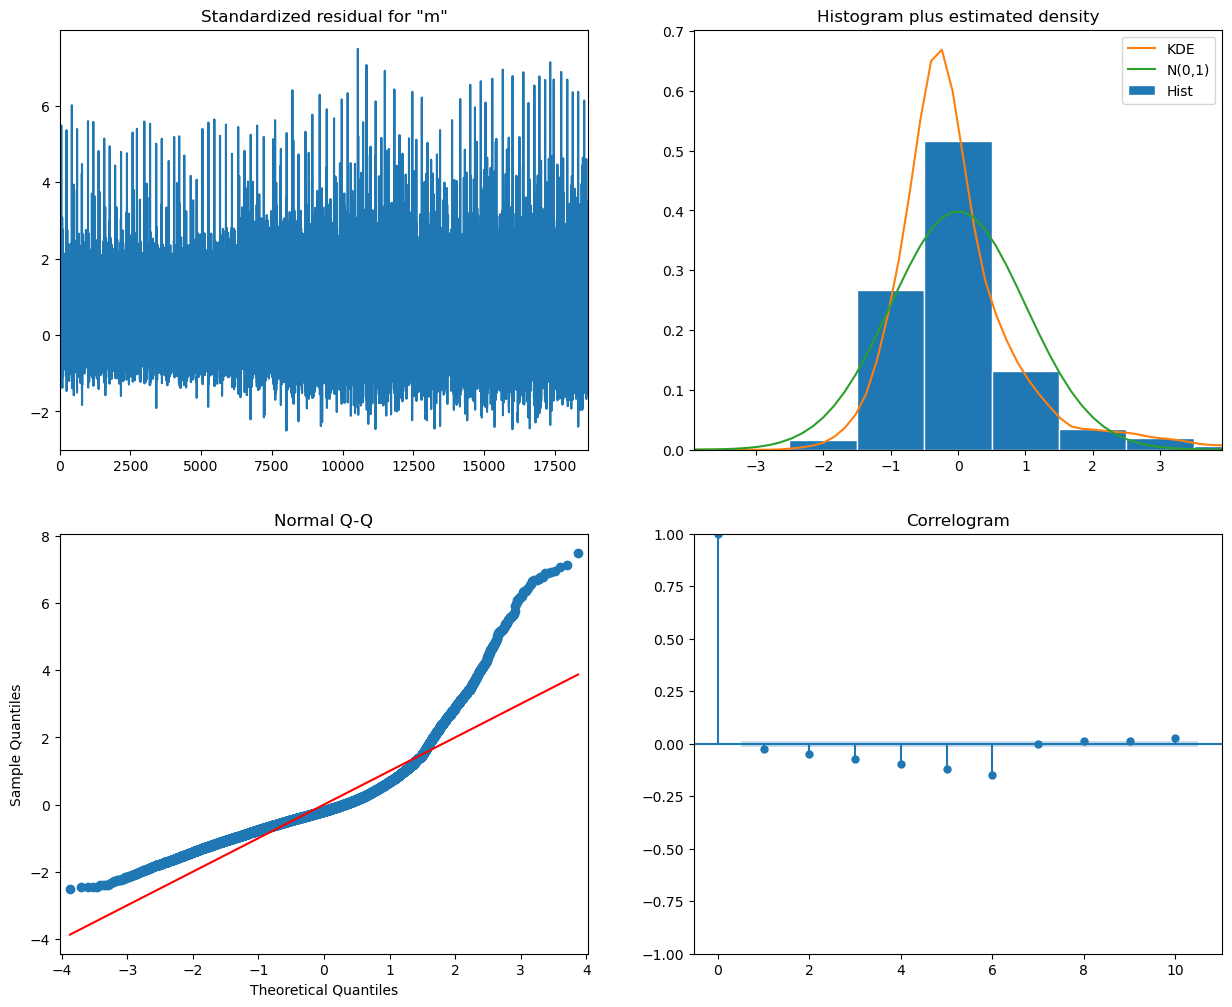

In [11]:
# Plot diagnostics
arima_result_510.plot_diagnostics(figsize=(15, 12))
plt.show()

/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

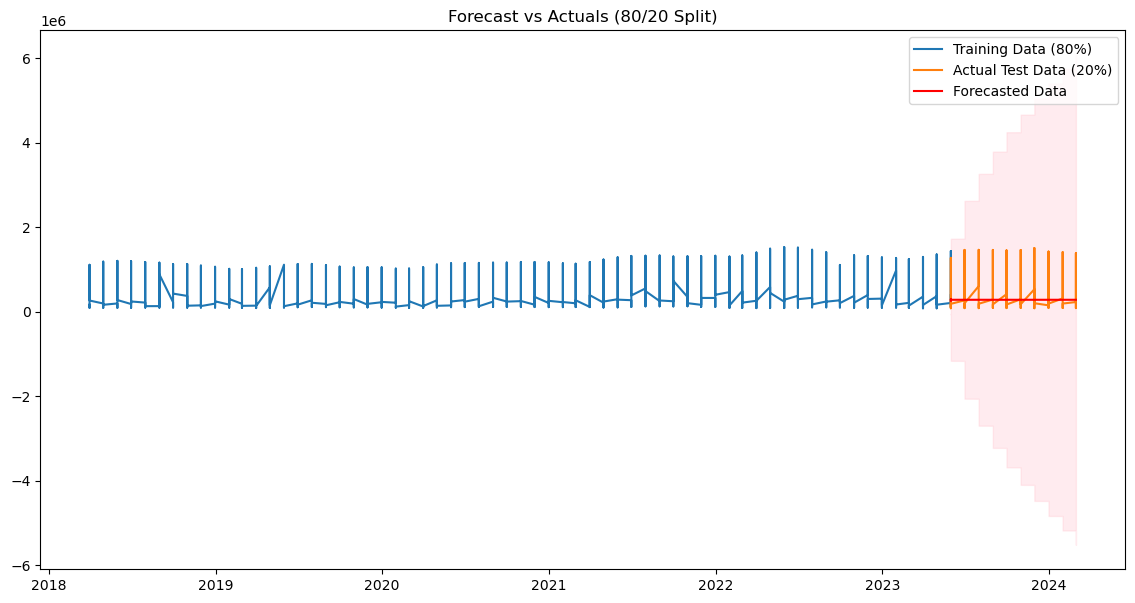

RMSE: 185238.26502196354


In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

median_sales_price = df['median sales price ($)']


# Calculate the index for an 80/20 split
split_idx = int(len(median_sales_price) * 0.8)

# Define the training and test sets based on 80/20 split
train = median_sales_price[:split_idx]
test = median_sales_price[split_idx:]

# Fit the ARIMA(5,1,0) model on the 80% training data
model = ARIMA(train, order=(5,1,0))
fitted_model = model.fit()

# Forecast for the length of the test set
forecast_result = fitted_model.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Calculate RMSE for the 80/20 split model
rmse = sqrt(mean_squared_error(test, forecast_mean))

# Plotting the results for 80/20 split
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data (80%)')
plt.plot(test.index, test, label='Actual Test Data (20%)')
plt.plot(test.index, forecast_mean, label='Forecasted Data', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actuals (80/20 Split)')
plt.legend()
plt.show()

print('RMSE:', rmse)


/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/maxguo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


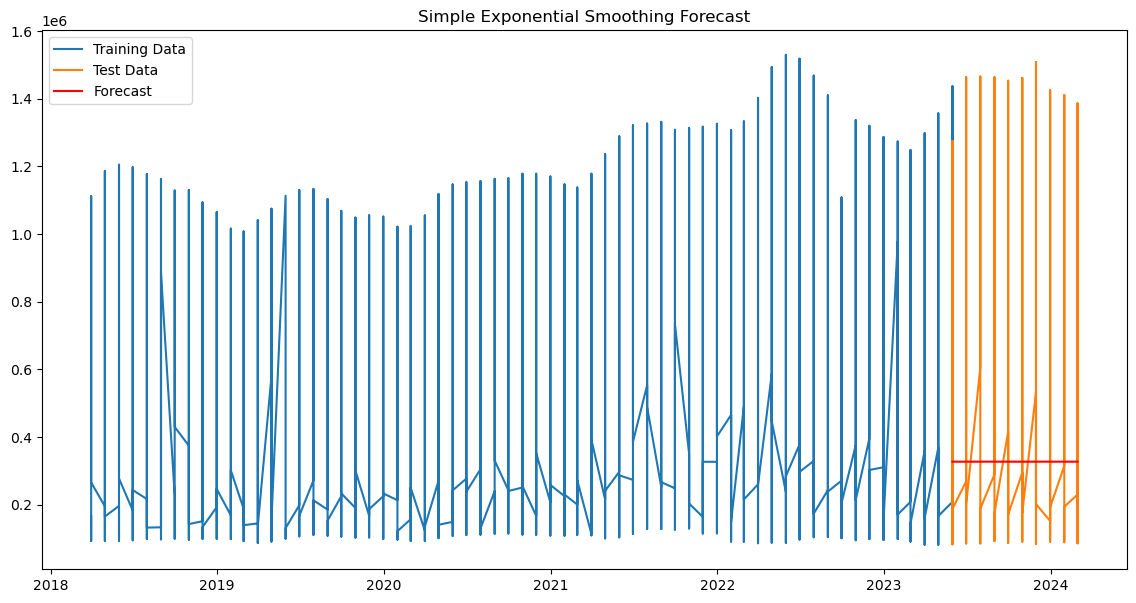

RMSE: 180529.614169209


In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Load the complete data for fitting
data_full = df['median sales price ($)']

# Calculate the split index
split_index = int(len(data_full) * 0.8)

# Split the data into training and testing
train_data = data_full[:split_index]
test_data = data_full[split_index:]

# Fit Simple Exponential Smoothing on training data
ses_model = SimpleExpSmoothing(train_data).fit()

# Forecast for the length of the test data
ses_forecast = ses_model.forecast(len(test_data))

# Calculate RMSE for the forecast
rmse = sqrt(mean_squared_error(test_data, ses_forecast))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, ses_forecast, label='Forecast', color='red')
plt.title('Simple Exponential Smoothing Forecast')
plt.legend()
plt.show()

print('RMSE:', rmse)
